<a href="https://colab.research.google.com/github/Adrita2211/ML_Project/blob/object_detection/image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 40.8 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import faiss
import os
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from google.colab.patches import cv2_imshow
from google.colab import drive
import os

In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Load pre-trained model and remove top layers
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [41]:
# Compute embeddings using VGG16
def compute_embeddings(images):
    embeddings = []
    for img in images:
        img = cv2.resize(img, (224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        img_embedding = model.predict(img)
        embeddings.append(img_embedding.flatten())
    return np.array(embeddings)

In [42]:
def create_index(embeddings):
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(embeddings)
    return index

In [43]:
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    image_paths = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            # Read image (modify based on your image types)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize if needed
                img = cv2.resize(img, target_size)
                # Convert color space if needed (BGR to RGB)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                image_paths.append(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(images), image_paths

In [44]:
folder_path = '/content/sample_data'  # Update this path
images, image_paths = load_images_from_folder(folder_path)
embeddings = compute_embeddings(images)
index = create_index(embeddings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [45]:
def search_similar_images(index, query_embedding, top_k=1):
    D, I = index.search(query_embedding, top_k)
    return I

In [49]:
similar_images_indices = []

# Call search_similar_images for each query embedding in the array
for query_embedding in embeddings:
    # Reshape the query embedding if necessary (e.g., for FAISS, it expects 2D array)
    query_embedding = query_embedding.reshape(1, -1)
    I = search_similar_images(index, query_embedding, top_k=1)
    similar_images_indices.append(I)  # Append I to the list

In [50]:
print("Similar images indices:", similar_images_indices)
for idx in similar_images_indices[0].flatten(): # Flatten the array to get individual indices
    print(image_paths[idx])

Similar images indices: [array([[0]]), array([[1]]), array([[2]]), array([[3]]), array([[4]])]
/content/sample_data/img_5.png


Query Image


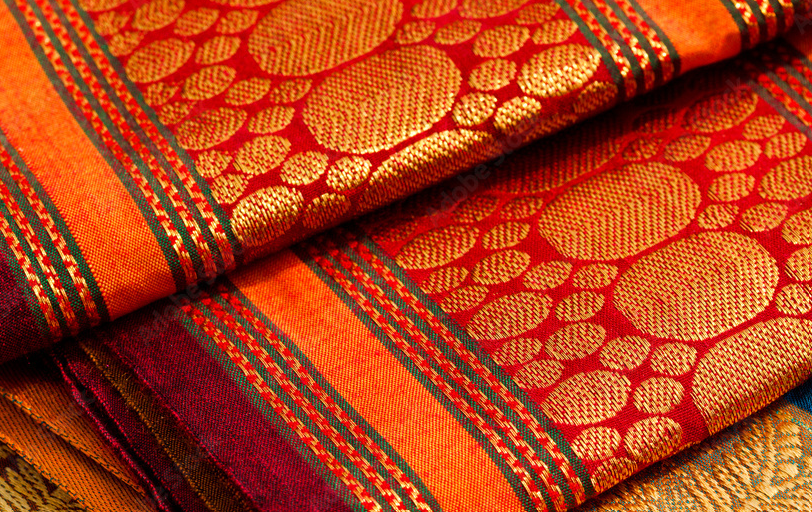

Most Similar Image


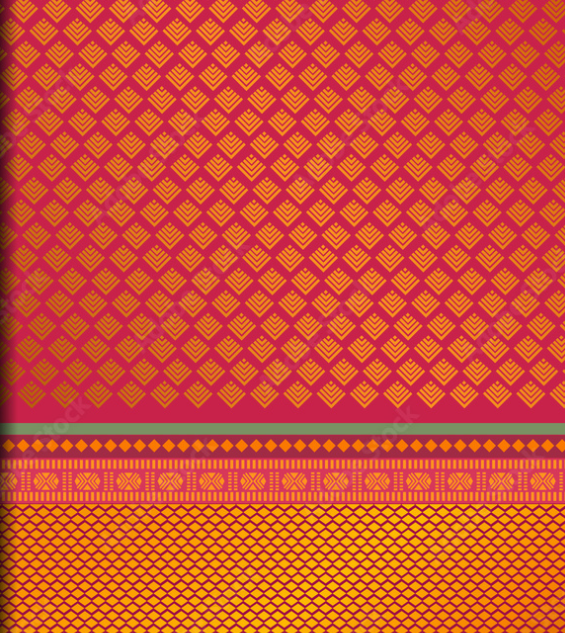

In [51]:
print("Query Image")
# Load the image using cv2.imread before displaying
query_image = cv2.imread("/content/sample_data/img_4.png")
cv2_imshow(query_image)  # Display the loaded image
cv2.waitKey(0)  # Wait for a key press to close the image

# Iterate through the similar image indices and display
for idx in similar_images_indices[0].flatten():  # Flatten the array to get individual indices
    # Now idx is a single integer and can be used as an index
    similar_image_path = image_paths[idx]
    similar_image = cv2.imread(similar_image_path)
    print("Most Similar Image")
    cv2_imshow(similar_image)
    cv2.waitKey(0)